In [1]:
import h5py
import numpy
import os
import scipy.io

In [2]:
from matplotlib import pyplot as plt

In [3]:
from utils.path import RAW_UP
from utils import file

1 = IEEE
2 = mat file

In [4]:
rawX1 = file.LoadTiff(os.path.join(RAW_UP, 'pavia_ds.tif'))
rawX2 = scipy.io.loadmat(os.path.join(RAW_UP, 'PaviaU.mat'))['paviaU']

/home/xdrl1/miniconda3/envs/hsidata/lib/python3.10/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [5]:
rawX1 = rawX1.transpose(1, 2, 0)
rawX1.shape, numpy.max(rawX1), numpy.min(rawX1)
rawX1 = rawX1[:, :340, :]

In [6]:
rawX2.shape, numpy.max(rawX2), numpy.min(rawX2)

((610, 340, 103), 8000, 0)

In [7]:
assert(numpy.all(rawX1 == rawX2))

Good. Two datasets store exactly the same copy of data. We can plot by freely choosing three channels.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


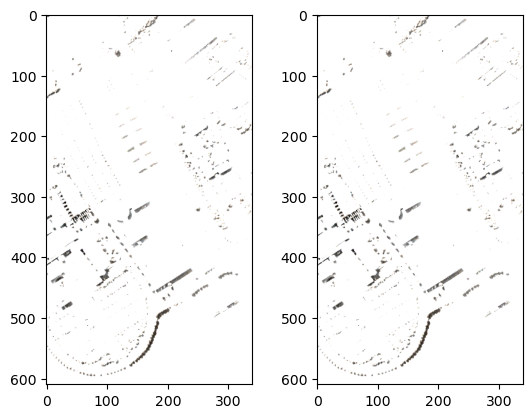

In [8]:
plt.subplot(121)
plt.imshow(rawX1[:, :, 34: 37])
plt.subplot(122)
plt.imshow(rawX2[:, :, 34: 37])

As `rawX1` and `rawX2` are the same, keeping one copy is enough.

In [9]:
rawX = rawX1
del rawX1, rawX2

Now it comes labels. This is also where the problem exists. First, we read two label files.

In [10]:
rawTrY = file.LoadTiff(os.path.join(RAW_UP, 'pavia_ts.tif'))
rawTrY = rawTrY[:, :340]
rawY = scipy.io.loadmat(os.path.join(RAW_UP, 'PaviaU_gt.mat'))['paviaU_gt']

Next, we try to unify the numbering of different land covers from two data sources.

In [11]:
name2IdxMAT = {
    "Asphalt": 1,
    "Meadows": 2,
    "Gravel": 3,
    "Trees": 4,
    "Painted metal sheets": 5,
    "Bare Soil": 6,
    "Bitumen": 7,
    "Self-Blocking Bricks": 8,
    "Shadows": 9,
}

name2IdxDASE = {
    "Asphalt": 8,
    "Meadows": 2,
    "Gravel": 3,
    "Trees": 9,
    "Painted metal sheets": 7,
    "Bare Soil": 6,
    "Bitumen": 5,
    "Self-Blocking Bricks": 1,
    "Shadows": 4,
}

In [12]:
print('#pixels for training for every category:\n')
print('MAT\t\tIEEE DASE'.rjust(40))
for plant in name2IdxMAT.keys():
    print(f"{plant:>24}: {(rawY==name2IdxMAT[plant]).sum()}\t\t{(rawTrY==name2IdxDASE[plant]).sum()}")

#pixels for training for every category:

                          MAT		IEEE DASE
                 Asphalt: 6631		548
                 Meadows: 18649		540
                  Gravel: 2099		392
                   Trees: 3064		524
    Painted metal sheets: 1345		265
               Bare Soil: 5029		532
                 Bitumen: 1330		375
    Self-Blocking Bricks: 3682		514
                 Shadows: 947		231


This result shows that our plant-to-index mappings for two datasets are matched according to other papers. We can also have a good figure.

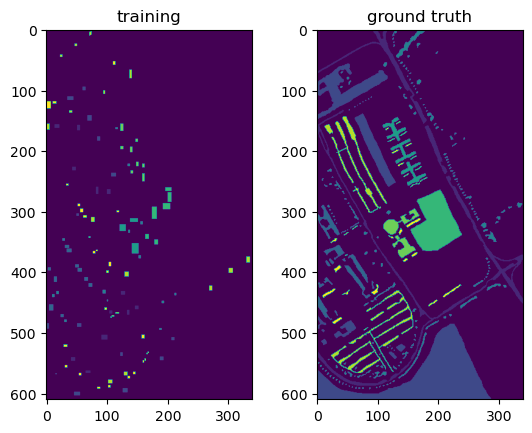

In [13]:
plt.subplot(121)
plt.title("training")
plt.imshow(rawTrY)
plt.subplot(122)
plt.title("ground truth")
plt.imshow(rawY)

Then we get the mask for training and testing.

In [14]:
bgMask = rawY == 0  # background mask
nbgMask = rawY != 0  # non-background mask
trMask = rawTrY != 0
teMask = (nbgMask.astype(int) - trMask.astype(int)).astype(bool)

Are all points for training are not `background` in ground truth?

In [15]:
numpy.sum(rawY[trMask] == 0)

1147

Sadly, no. 1147 pixels are background in ground truth, and they should not be background.

Similarly, are all `background` pixels in ground truth are still `background` in training (they should be)?

In [16]:
numpy.sum(rawTrY[bgMask] != 0)

1147

Still, no. There are 1147 `background` pixels in ground truth are with labels that are not `background` for training.
The previous two results match with each other, revealing that there are errors either in the IEEE DASE train test split or the `.mat` file that is widely used in many papers. Why not visualize where are these 1147 pixels?

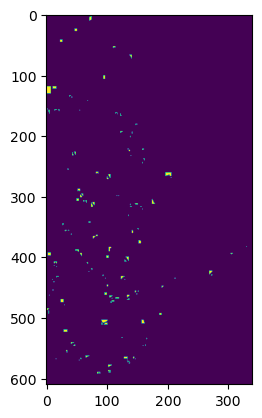

In [17]:
tmpTrY, tmpY = rawTrY == 0, rawY == 0
res = tmpY.astype(int) - tmpTrY.astype(int)
res[res==-1] = 0
plt.imshow(res)

Therefore, I decided not to use this dataset, at least where I claim I am using IEEE DASE disjoint train/test split.